# **Lab 01 - Large Language Models**

---

## **Lab 01:** Introduction to Deep Learning Models, and their Training, Fine-Tuning, and Evaluation

In this lab, we will explore the basic functionality of PyTorch, focusing on key operations such as data loading, data transformations, and using GPUs for acceleration. You will be introduced to fundamental components like **Tensors**, **DataLoaders**, and **Neural Networks** that are essential for building and training deep learning models.

The lab is divided into several exercises, each designed to provide hands-on experience with different PyTorch features. You will begin by creating a very simple neural network on a very simple problem, with all that is involved (i.e., model creation, dataset and data loader creation, training loop). Then you will move on to applying transformations to the **CIFAR-10 dataset**, creating a **DataLoader**, and moving computations to a GPU (if available). As you progress through the exercises, you will deepen your understanding of PyTorch's capabilities.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

#### Tensors
**Tensors** in PyTorch Tensors are the primary data structure in PyTorch. They are similar to NumPy arrays but have added functionality that supports GPU acceleration and automatic differentiation (*autograd*).

In [2]:
# Create a tensor
a = torch.tensor([1.0, 2.0, 3.0])

# Perform basic tensor operations
b = torch.tensor([4.0, 5.0, 6.0])
c = a + b  # Element-wise addition
print(f"Tensor c: {c}")

# Check tensor's shape and type
print(f"Shape of tensor c: {c.shape}")
print(f"Data type of tensor c: {c.dtype}")

Tensor c: tensor([5., 7., 9.])
Shape of tensor c: torch.Size([3])
Data type of tensor c: torch.float32


Note that torch tensors use, by default, float32 (single precision) data type. NumPy, instead, defaults to float64 (double precision).

This happens for performance-related reasons: float32 operations are faster than float64, as the following code snippet shows.

In [3]:
from timeit import timeit

mat_size = 1000

M1_64 = torch.randn(mat_size, mat_size, dtype=torch.float64)
M2_64 = torch.randn(mat_size, mat_size, dtype=torch.float64)

M1_32 = torch.randn(mat_size, mat_size)
M2_32 = torch.randn(mat_size, mat_size)

t64 = timeit(lambda: M1_64 @ M2_64, number=100)
t32 = timeit(lambda: M1_32 @ M2_32, number=100)

print(f"Time for matrix multiplication (float64): {t64:.4f}s")
print(f"Time for matrix multiplication (float32): {t32:.4f}s")

Time for matrix multiplication (float64): 3.0606s
Time for matrix multiplication (float32): 1.4586s


The additional precision obtained with float64 is not typically necessary.

If strictly needed, you can change the data type of a tensor using the .to() method. For example, to convert tensor c to float64 (double precision), you can use the following code:

```python
c = c.to(torch.float64) # or,
c = c.double()
```

---

## **Exercise 1: A simple neural network**

### **1.1 Building and Understanding the Simple Linear Model**

In this exercise, we implement a simple linear model using PyTorch to understand the foundational concepts of model parameters, including **weights** and **biases**. A univariate linear model is one of the most basic forms of machine learning models and is defined by the equation $y = wx + b$

where:
- $x$ is the input feature,
- $w$ is the weight,
- $b$ is the bias,
- $y$ is the output or prediction.

#### **Model Definition: SimpleLinearModel**

The `SimpleLinearModel` class is a subclass of `nn.Module`, which is the base class for all neural network modules in PyTorch. This class defines a single linear layer using `nn.Linear`, which performs the linear transformation:

`output = input * w + b`

The `SimpleLinearModel` class is structured as follows:

- **`__init__(self, input_size, output_size)`**:
  - This is the constructor method where the linear layer is defined. The `input_size` and `output_size` parameters specify the dimensions of the input and output features, respectively. In this exercise, both the input and output sizes are set to 1, indicating a single feature input and a single prediction output.

- **`forward(self, x)`**:
  - This method defines the forward pass of the model, where the input `x` is passed through the linear layer. The forward pass computes the output by applying the linear transformation described above.

This simple model is trained on a synthetic dataset to learn the relationship between the input features and the target labels. During training, the model iteratively adjusts its weights `w` and bias `b` to minimize the error between the predicted and actual outputs. After training, we can inspect these learned parameters to understand how the model has adapted to the data.

In [36]:
# Define a simple linear model
class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

In [37]:
# Initialize the model, loss function, and optimizer
model = SimpleLinearModel(1, 1)

#### Using `torch.device` for GPU Acceleration

PyTorch provides seamless support for running operations on both CPUs and GPUs using the `torch.device` object. By leveraging the computational power of GPUs, we can significantly speed up the training process of deep learning models, especially when working with large datasets and complex networks.

In this example, we first check if a GPU is available on the machine. In particular, we check if CUDA is available: CUDA is a software layer that provides an interface to the underlying hardware (GPU). If CUDA (and, as a consequence, a GPU) is detected, the tensors are moved to the GPU memory to accelerate computations. Otherwise, the computations fall back to the CPU (i.e., the tensor are kept on the main memory). This flexibility allows the same code to run efficiently on both CPU-only systems and systems equipped with GPUs.

The `torch.device` method is a convenient way to handle this device-agnostic approach, ensuring that tensors and models are placed on the correct device before training or inference.


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"The device is set to: {device}")

The device is set to: cuda


So now we can move the model to the currently selected device (either cuda, or cpu).

In [39]:
model = model.to(device)

---
Note that the model has a `linear` attribute (which we created). This layer has its own attributes: `weight` and `bias`. These are the parameters that the model will learn during training.

The initial values are randomly generated, and the model will adjust them during training to minimize the loss function.

Finally, note that these tensors have the `requires_grad` attribute set to `True`. This attribute is used by PyTorch to determine which tensors should have their gradients computed during the backward pass (i.e., which tensors are learnable parameters). This is used by PyTorch to keep track of the computational graph.

In [40]:
print("Weight", model.linear.weight)
print("Bias", model.linear.bias)

Weight Parameter containing:
tensor([[0.1928]], device='cuda:0', requires_grad=True)
Bias Parameter containing:
tensor([0.0241], device='cuda:0', requires_grad=True)


#### Criterion and Optimizer

In deep learning, two crucial components used during the training process of a model are the **criterion** and the **optimizer**. Understanding these components is essential for effectively training and fine-tuning neural networks.

##### Criterion (Loss Function)

The **criterion**, also known as the **loss function**, is a measure of how well the model's predictions match the actual target values. During training, the loss function evaluates the difference between the predicted outputs and the true labels, quantifying the error of the model. The goal of training is to minimize this error, thereby improving the model's accuracy.

Common loss functions include:

- **Cross Entropy**: Used for multi-class classification problems, like our CIFAR-10 and CIFAR-100 tasks. We typically use PyTorch's `CrossEntropyLoss`, which takes as input the predicted *logits* (not the probabilities, so unnormalized probabilities that have not been passed through a softmax) is applied) and the ground truths. Alternatively, we could combine `LogSoftmax` and `NLLLoss` (Negative Log Likelihood Loss) together, or applying the softmax ourselves and then using a Negative Log Likelihood function. However, for numerical reasons, we generally prefer using the `CrossEntropyLoss` class directly.
- **Mean Squared Error (MSE)**: Typically used for regression tasks, where the model predicts continuous values.

In this exercise, we use a Mean Squared Error loss, since the task involves predicting a continuous value.

##### Optimizer

The **optimizer** is an algorithm or method used to adjust the model's weights to minimize the loss function. It updates the model parameters (weights and biases) based on the gradients computed during backpropagation. The optimizer aims to find the optimal set of parameters that reduce the loss, improving the model’s performance on the training data.

Some common optimizers include:

- **Stochastic Gradient Descent (SGD)**: A basic optimizer that updates the model parameters using a small, randomly selected subset of data (mini-batch) instead of the entire dataset. It’s useful for handling large datasets and reducing computational cost.
- **Adam**: A more advanced optimizer that combines the benefits of two other extensions of SGD, Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). It adjusts the learning rate for each parameter dynamically, making it well-suited for complex tasks with sparse gradients.

In this exercise, we use **Stochastic Gradient Descent (SGD)** as our optimizer.

In [41]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In deep learning tasks, the `DataLoader` and *datasets* provided by PyTorch are essential tools for efficiently handling large datasets and batching input data for model training.

If we have a "traditional" dataset (e.g., an X matrix and a y vector), we can use the `TensorDataset` class to wrap the input and target tensors. This class allows us to access a slice of the dataset using the index notation (e.g., `dataset[0:10]`).

The `DataLoader` class is used to load data from a `Dataset` object. It provides features such as shuffling, batching, and parallel data loading, making it easier to iterate over the dataset during training.

In [42]:
# Create a dataset (for simplicity, we use a small synthetic dataset)
# X is the input features, y is the target labels

n_pts = 2048
# TODO: Generate a random dataset containing n_pts samples
# Notes:
# - The input features X should be a tensor of shape (n_pts, 1)
# - you can generate the X's randomly (e.g. using torch.rand to sample uniformly from [0,1], or torch.randn to sample from a normal distribution)
# - The target labels y should be a linear function of X with some noise added, y = w*x + b + gaussian noise
X = torch.rand(n_pts, 1)
y = 5 * X + 3 + 0.1 * torch.randn(n_pts, 1)

# Create DataLoader
dataset = TensorDataset(X, y)
trainloader = DataLoader(dataset, batch_size=256, shuffle=True)

### Training Loop

The **training loop** is the core component of the training process in deep learning. It involves repeatedly passing the training data through the model, computing the loss, and updating the model's parameters to minimize the loss. Understanding the training loop is essential for effectively training neural networks and fine-tuning models to achieve high performance.

The training loop typically consists of several key steps that are executed for a number of **epochs** (iterations over the entire dataset). Let's break down the principal functions of the training loop:

1. **Forward Pass**

   During the forward pass, the input data is fed through the neural network to produce predictions. These predictions are compared to the actual labels using the **criterion** (loss function) to compute the loss. This step involves:
   
   - Passing the input data to the model.
   - Computing the model's output (predictions).
   - Calculating the loss by comparing the model’s predictions to the true labels.

2. **Loss Computation**

   The computed loss indicates how well or poorly the model is performing on the training data. The goal is to minimize this loss, so it acts as a guide for the optimizer to adjust the model's weights. The loss function provides a differentiable quantity that the optimizer can use to update the model parameters.

3. **Backward Pass (Backpropagation)**

   The backward pass, also known as **backpropagation**, is where the gradients of the loss with respect to each model parameter are calculated. These gradients indicate how much each parameter contributes to the loss, and they are used to update the model's parameters in the direction that reduces the loss:
   
   - Compute the gradients by performing backpropagation.
   - These gradients are stored for use by the optimizer.

4. **Parameter Update**

   After computing the gradients, the **optimizer** uses them to update the model's parameters (weights and biases). This step adjusts the parameters to minimize the loss function. The optimizer’s update rule determines how the parameters are changed based on the gradients, the learning rate, and potentially other factors (like momentum or weight decays). This involves:
   
   - Using the optimizer to adjust the model's parameters based on the computed gradients.
   - Updating the weights to reduce the loss on the next forward pass.

5. **Zero the Gradients**

   After updating the parameters, the gradients need to be zeroed before the next iteration. This step ensures that gradients from the previous batch do not accumulate with those from the current batch, which could lead to incorrect updates:
   
   - Set the gradients to zero using `optimizer.zero_grad()` to prevent accumulation from previous batches.

6. **Repeat for All Batches and Epochs**

   The above steps are repeated for each batch in the dataset and for each epoch until the model converges to an optimal solution or reaches the desired number of epochs. Over multiple epochs, the model learns to generalize better to the training data and, ideally, to new, unseen data.

In summary, the training loop is a repetitive process that allows the model to learn from the data by minimizing the loss through gradient-based optimization. Understanding each function within the loop is crucial for successfully training deep learning models and fine-tuning them for specific tasks.


In [43]:
# Training loop
num_epochs = 50

# TODO: keep track of the loss computed at each step,
# the current value for the weight of the linear layer,
# and the current bias value for the linear layer.
# Note: store the values in the lists losses, weights, biases
losses = []
weights = []
biases = []

model.train() # Set the model in training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        weights.append(model.linear.weight.data.item())
        biases.append(model.linear.bias.data.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")


Epoch [1/50], Loss: 25.9017
Epoch [2/50], Loss: 17.3757
Epoch [3/50], Loss: 11.7098
Epoch [4/50], Loss: 7.9440
Epoch [5/50], Loss: 5.4387
Epoch [6/50], Loss: 3.7710
Epoch [7/50], Loss: 2.6602
Epoch [8/50], Loss: 1.9198
Epoch [9/50], Loss: 1.4250
Epoch [10/50], Loss: 1.0934
Epoch [11/50], Loss: 0.8700
Epoch [12/50], Loss: 0.7185
Epoch [13/50], Loss: 0.6151
Epoch [14/50], Loss: 0.5436
Epoch [15/50], Loss: 0.4934
Epoch [16/50], Loss: 0.4573
Epoch [17/50], Loss: 0.4306
Epoch [18/50], Loss: 0.4103
Epoch [19/50], Loss: 0.3941
Epoch [20/50], Loss: 0.3810
Epoch [21/50], Loss: 0.3697
Epoch [22/50], Loss: 0.3599
Epoch [23/50], Loss: 0.3510
Epoch [24/50], Loss: 0.3428
Epoch [25/50], Loss: 0.3351
Epoch [26/50], Loss: 0.3278
Epoch [27/50], Loss: 0.3208
Epoch [28/50], Loss: 0.3140
Epoch [29/50], Loss: 0.3075
Epoch [30/50], Loss: 0.3011
Epoch [31/50], Loss: 0.2949
Epoch [32/50], Loss: 0.2888
Epoch [33/50], Loss: 0.2829
Epoch [34/50], Loss: 0.2771
Epoch [35/50], Loss: 0.2714
Epoch [36/50], Loss: 0.265

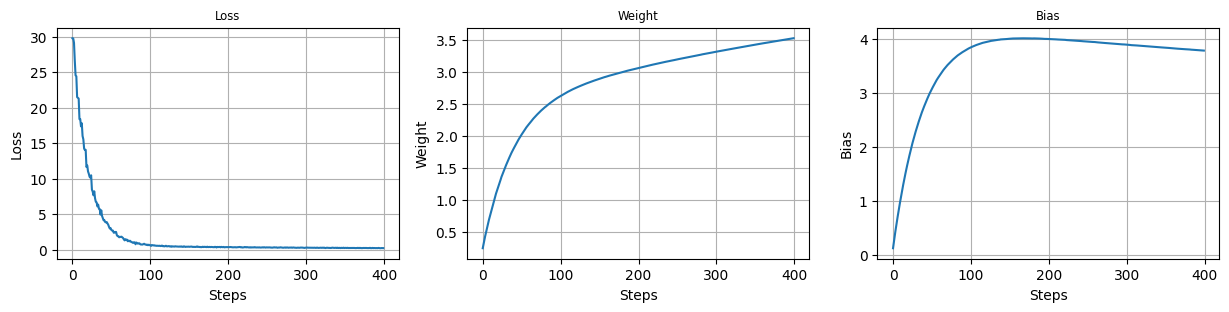

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(losses)
ax[0].set_title("Loss")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(weights)
ax[1].set_title("Weight")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Weight")
ax[1].grid()

ax[2].plot(biases)
ax[2].set_title("Bias")
ax[2].set_xlabel("Steps")
ax[2].set_ylabel("Bias")
ax[2].grid()

In [45]:
# Inspecting the learned weights and biases
weights = model.linear.weight.data
biases = model.linear.bias.data

print(f'Learned weights: {weights}')
print(f'Learned biases: {biases}')

Learned weights: tensor([[3.5284]], device='cuda:0')
Learned biases: tensor([3.7820], device='cuda:0')


---
## **Exercise 2: First Model Training**

In this exercise, you will explore the concept of **transfer learning** by training a model on the **CIFAR-10 dataset** and then adapting it to a different dataset, **CIFAR-100**.

Transfer learning is a powerful technique in deep learning where a model developed for a particular task is reused as the starting point for a model on a second task. This approach is especially useful in fields like **Natural Language Processing (NLP)**, where training a model from scratch requires immense computational resources and vast amounts of data. Instead, pre-trained models are often used as backbones, and only the final classification head is fine-tuned for specific tasks. This is also sometimes done for **Large Language Models (LLMs)**, although we often go a step further and not even fine-tune models, but use them with *in-context learning*. This, however, is a topic for later time.

In this exercise, you will see how transfer learning works in practice using image datasets, but the principles you'll learn are directly applicable to NLP and LLMs, which are a major focus of this course. Understanding how to fine-tune pre-trained models is crucial because it's a common technique used to adapt powerful language models to a wide range of applications, such as sentiment analysis, text classification, or question answering.

The **CIFAR-10** and **CIFAR-100** datasets are both standard datasets in computer vision. They contain 32x32 color images, but while CIFAR-10 has 10 classes, CIFAR-100 has 100 classes, making it a more challenging task.

In this exercise, you will:
1. **Train a model from scratch on CIFAR-10** and evaluate its performance.
2. **Compare the performance on CIFAR-10** of two models:
   - The model trained from scratch from point 1.
   - A model pre-trained on ImageNet (another dataset of images) and then fine-tuned on CIFAR-10.
3. **Modify the classification head** to adapt the model for CIFAR-100.

By the end of this exercise, you will have a deeper understanding of the benefits of transfer learning and how pre-training can significantly improve the performance of deep learning models, especially in NLP and with LLMs, on new tasks with limited data.

---

#### Loading the CIFAR-10 Dataset and Creating a DataLoader

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 testing images.

The process starts by downloading the dataset. Torchvision support the CIFAR-10 dataset, so we can use the `CIFAR10` class to download the dataset directly.

We apply a simple transformation to the images, which start out as PIL images ([PIL](https://pypi.org/project/pillow/) is a famous Python libraries that handles images), to convert them into PyTorch tensors. We do this using the `transforms.ToTensor()` transformation.

Next, we will apply various transformations that will be shown to be useful for the learning task. These transformations help prepare the data for training by normalizing and augmenting the images.

After that, we will use a `DataLoader`, which allows us to efficiently load batches of data and shuffle them during training.

Once the dataset is loaded into the DataLoader, we can fetch a batch of data and inspect its shape to verify that everything is working as expected.


In [46]:
dataset_dir = "~/data"

In [47]:
# Download CIFAR-10 dataset and apply the transformations
trainset = torchvision.datasets.CIFAR10(
    root=dataset_dir, train=True, download=True, transform=transforms.ToTensor()
)

# Create a DataLoader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)

# Get a batch of data to verify that everything is working
# dataiter = iter(trainloader)
images, labels = next(iter(trainloader)) #dataiter.next()

print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")
print(f"Possible classes: {', '.join(trainset.classes)}")

Batch of images shape: torch.Size([64, 3, 32, 32])
Batch of labels shape: torch.Size([64])
Possible classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


Note that the batch size is of 64x3x32x32:
- 64 is the batch size, i.e. how many images are processed at once by the model
- 3 is the number of channels (RGB)
- 32x32 is the size of the image

We can plot these images in an 8x8 grid to get a sense of what they look like.

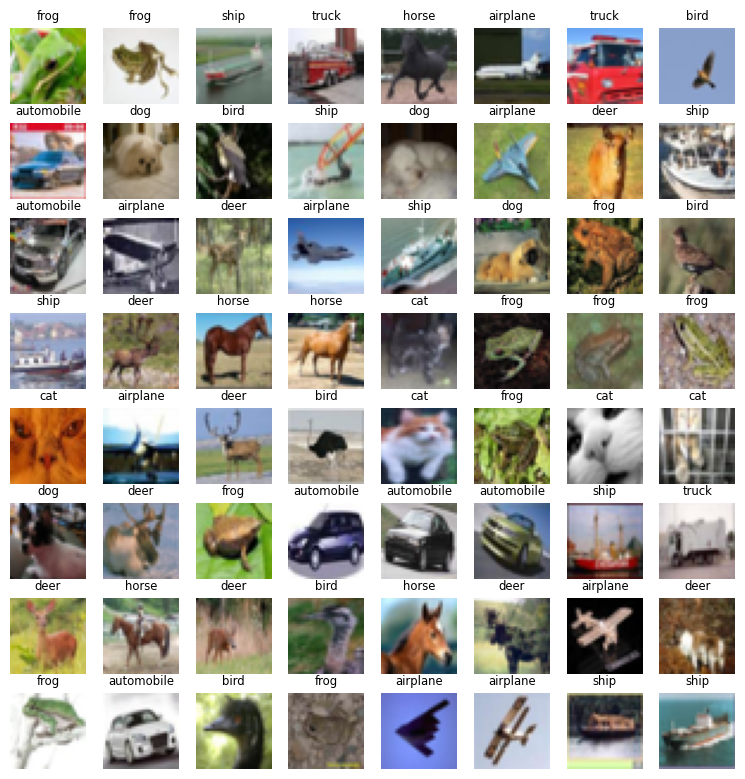

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(8,8, figsize=(8,8))
plt.rcParams.update({'axes.titlesize': 'small'})
plt.tight_layout()
# remove vertical space
plt.subplots_adjust(hspace=0.25, wspace=0.1)

for i in range(8):
    for j in range(8):
        # note that we need to change the order of the dimensions.
        # Torch prepare the images to be (C, H, W),
        # But matplotlib expects (H, W, C)
        # (H = height of the image, W = width of the image, C = number of color channels)
        ax[i,j].imshow(images[i*8 + j].permute(1,2,0))
        ax[i,j].set_title(trainset.classes[labels[i*8 + j]])
        ax[i,j].axis('off')

---

#### Data Transformations

In deep learning, especially in computer vision tasks, **data transformations** are crucial for preparing input data to enhance model performance and generalization. Transformations involve modifying the inputs (e.g., images) in the dataset to make the model more robust to variations in input data and prevent overfitting.

In this exercise, we will apply several common transformations to the CIFAR-10 and CIFAR-100 datasets. It's important to note that the transformations applied to the **training** data differ from those applied to the **validation** data:

##### Training Transformations
Training transformations are designed to augment the dataset, effectively increasing the diversity of the input images seen by the model during training. This helps improve the model's ability to generalize to unseen data. Common training transformations include:

1. **Random Crop**: Randomly crops a given portion of an image. This helps the model become invariant to the position of objects within the image.
2. **Random Horizontal Flip**: Randomly flips an image horizontally. This technique ensures that the model learns features regardless of the orientation of objects.
3. **Normalization**: Adjusts the pixel values to have a mean of 0 and a standard deviation of 1. Normalization helps speed up training and can lead to better model performance.

##### Validation Transformations
Validation transformations, on the other hand, are intended to provide a consistent evaluation of model performance by ensuring the input data is in a standardized format. Typically, validation transformations include:

2. **Normalization**: Similar to training, normalization is applied to adjust the pixel values to have a mean of 0 and a standard deviation of 1. This ensures that the distribution of values in the validation samples is the same one used in the training samples (since the model already learned to expect that distribution of values).

So, the key difference is that training transformations often include **random augmentations** (such as cropping and flipping) to introduce variability, whereas validation transformations are more standardized and deterministic to provide a stable basis for evaluating the model's performance.

In [49]:
# TODO: find the mean value and the standard deviation of the images in the dataset
# Note:
# - The images are available in trainset.data
# - Scale the images to the [0,1] range before proceeding
# - Compute a different mean and standard deviation for each color channel
images_mean = trainset.data.mean(axis=(0,1,2)) / 255
images_std = trainset.data.std(axis=(0,1,2)) / 255

In [50]:
transform_train_example = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally for the data augmentation
    transforms.RandomCrop(32, padding_mode='reflect', padding=5),  # Randomly crop the image for the data augmentation
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(images_mean, images_std)  # Normalize the tensor
])

To apply the transformations, we can pass the transformation objects to the `transform` argument of the `CIFAR10` class. This way, the transformations are automatically applied when loading the data using the `DataLoader`.

Let's see what the same image looks like after applying these transformations.

Note that we are creating a different transformation, without the normalization step (& conversion to tensor), for the visualization. This occurs because the normalization step would make the image look strange, as it would change the pixel values to have a mean of 0 and a standard deviation of 1.

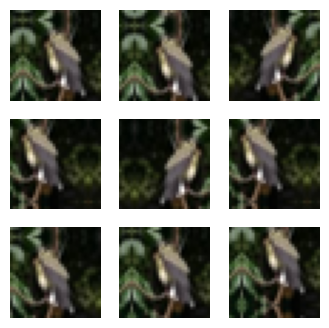

In [60]:
viz_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # note the padding_mode policy: this implies that the "missing" pixels
    # will be reflected from the border pixels
    # (more info in the documentation => https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html)
    transforms.RandomCrop(32, padding_mode='reflect', padding=5)
])

im = transforms.ToPILImage()(images[10])
n_transforms = 9

fig, ax = plt.subplots(3,3, figsize=(4,4))
# TODO: Visualize the original image, then apply different transformations to it
# Note: each time you apply the viz_transform transformation, a random transformation will be applied to the image

for i in range(3):
    for j in range(3):
        ax[i,j].imshow(viz_transform(im))
        ax[i,j].axis('off')

<span style="color:red">Extra stuff!</span>

Other transformations are already supported in PyTorch, such as:
- **RandomRotation**: Rotates the image by a random angle.
- **RandomResizedCrop**: Crops the image to a random size and aspect ratio, then resizes it to the specified size.
- **ColorJitter**: Randomly changes the brightness, contrast, saturation, and hue of an image.
- **RandomAffine**: Applies a random affine transformation to the image.
- **RandomPerspective**: Applies a random perspective transformation to the image.
- **RandomErasing**: Randomly selects a rectangle region in an image and erases its pixels.

You can find out more about those transformations in the [official documentation](https://pytorch.org/vision/stable/transforms.html).

Try applying some of these transformations to the CIFAR-10 dataset and observe how they affect the images. You can also experiment with different parameters to see how they influence the results.

In [57]:
# Download CIFAR-10 dataset and apply the transformations
trainset = torchvision.datasets.CIFAR10(
    root='/home/fgiobergia/data', train=True, download=True, transform=transform_train_example
)

# Create a DataLoader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)

100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


---



---

### **2.0 Building and Training a Simple Neural Network for CIFAR-10 Classification**

In this exercise, we extend our exploration of machine learning models by constructing a simple neural network to classify images from the CIFAR-10 dataset using PyTorch. Unlike the linear model, which is limited to learning linear relationships between features, this neural network introduces multiple layers and non-linear activation functions, allowing it to capture more complex patterns in the data.

A neural network consists of interconnected layers of nodes, or neurons, where each layer applies a linear transformation to its input, followed by a non-linear activation. The architecture we will implement includes:

1. **Input Layer**: Accepts the flattened input image, with each pixel value as a feature.
2. **Hidden Layers**: Two fully connected layers that transform the input into higher-level features using linear transformations and ReLU activation functions.
3. **Output Layer**: A final fully connected layer that maps the transformed features to the 10 output classes of the CIFAR-10 dataset.

By training this model, we aim to understand how neural networks can learn complex representations of data, enabling them to perform more sophisticated tasks such as image classification. This exercise will also introduce key concepts such as non-linearity, deep learning, and the importance of layer depth in enhancing model performance.

In [61]:
# Define a more complex neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # TODO: Define the linear layers for the model
        # Notes:
        # - Each layer requires specifying the number of input and output features
        # - The first layer takes as input a flattened image (32x32x3) and should produce 512 features
        #   (i.e., it encodes the image into a 512-dimensional space)
        # - The second layer should produce 256 features
        # - The output layer should produce 10 features (these will be the logits)

        # number of input features: 32*32*3 (image size)
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # TODO: implement the forward pass
        # Notes:
        # - first step: flatten the input (preserve the batch size, flatten the rest)
        # - apply the first linear layer with ReLU activation
        # - apply the second linear layer with ReLU activation
        # - apply the output layer (no activation needed for the output layer)
        x = x.view(-1, 32*32*3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Data Transformations

Note that we are using fixed means and standard deviations for the normalization step. These values are the means and stds of the ImageNet dataset, which has been used to pretrain the ResNet model (so the model now expects this normalization!).

In [62]:
# Define transformations for the training and test datasets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding_mode='reflect', padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#### Loading the CIFAR-10 Dataset

In [63]:
# Load CIFAR-10 dataset
batch_size = 1024
trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [64]:
# Initialize the model, loss function, and optimizer
model = SimpleNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [65]:
def val_model(model, testloader):
    model.eval() # NOTE: required to set the model to evaluation mode (some layers may behave differently during training and evaluation)
    correct = 0
    total = 0
    with torch.no_grad(): # NOTE: we disable gradient tracking for validation, to save memory!
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on the test images: {100 * correct / total:.2f}%")

In [66]:
val_model(model, testloader)

Accuracy of the network on the test images: 10.93%


In [67]:
# Training loop
num_epochs = 5

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # TODO: let's implement the training loop for the model
        # Notes:
        # - First, zero the parameter gradients
        # - Next, get the model's predictions
        # - Compute the loss
        # - Perform backpropagation (i.e. compute all gradients)
        # - Finally, update the model's parameters

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/5], Loss: 2.0931
Epoch [2/5], Loss: 1.8526
Epoch [3/5], Loss: 1.7506
Epoch [4/5], Loss: 1.6916
Epoch [5/5], Loss: 1.6499


<span style="color:red">Extra stuff!</span>

Now the model has a bunch more weights and biases (parameters) to learn. Unlike before, we don't know exactly what the "right" values should be. Pick a few random parameters from the various layers and keep track of how their values change over time!

(Note: make sure to extract the values from the tensors using the .item() method, as shown in the previous example, otherwise the computation graph will keep track of the values and you will run out of memory!)


Let's check the model's performance on the validation set.

In [68]:
val_model(model, testloader)

Accuracy of the network on the test images: 46.22%


Additionally, we can visualize the loss behavior over time. This can help us reach a few conclusions about the training process.

For instance, a "noisy" loss may indicate that the learning rate may be too large, or that the batch size is too small. If, after reaching the target number of epochs, the loss is still decreasing, it may be a sign that the model could benefit from additional training epochs.

Text(0, 0.5, 'Loss')

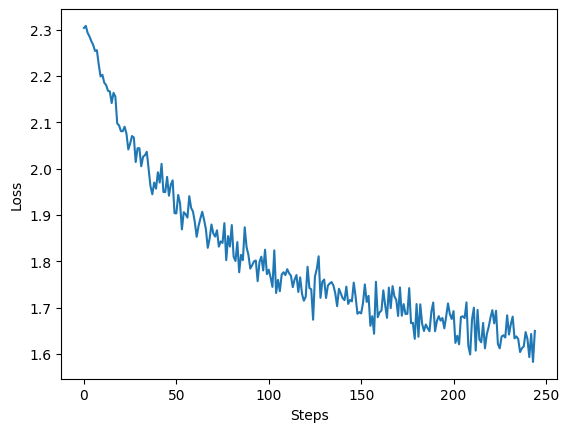

In [69]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

<span style="color:red">Extra stuff!</span>

While this model performs better than random guess (~10% accuracy), it still far from perfect. Compute the confusion matrix on the validation set. Which classes does the model classify better? Which classes does it struggle with? Which classes are most often confused with each other?

### **2.1 Load and Train a Model on CIFAR-10**

In [70]:
# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

In [71]:
from torchvision import models

# Load a pre-trained model (ResNet18)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)

In [72]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [73]:
# Training loop
num_epochs = 5

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/5], Loss: 1.7392
Epoch [2/5], Loss: 1.4002
Epoch [3/5], Loss: 1.2578
Epoch [4/5], Loss: 1.1516
Epoch [5/5], Loss: 1.0675


In [74]:
# Validate the model
val_model(model, testloader)

Accuracy of the network on the test images: 63.00%


Text(0, 0.5, 'Loss')

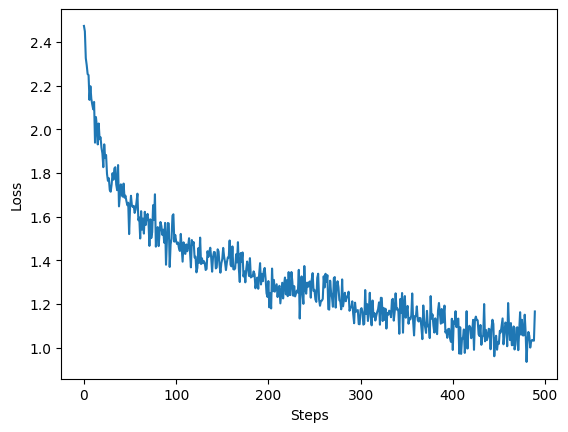

In [75]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

### **2.2 Load and Train a pre-trained Model on CIFAR-10**

In this exercise, we will load a pre-trained model (ResNet-18) from PyTorch's model zoo, modify it to fit the CIFAR-10 dataset, and fine-tune it. The pre-trained model has been trained on the ImageNet dataset, a large-scale dataset with 1.2 million images across 1000 classes. By leveraging the pre-trained model's knowledge, we can significantly reduce the training time and computational resources required to achieve high performance on CIFAR-10.

In [76]:
# TODO: Load a pre-trained model (ResNet18)
# Notes:
# - To load a pre-trained model, call models.resnet18 and set the weights argument to 'DEFAULT'
# - The model has a fully connected layer at the end (called `fc`) that needs to be replaced with a new one of the appropriate size
# - To get the number of input features for the new layer, you can access the in_features attribute of the original fc layer


pretrained_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 10)  # CIFAR-10 has 10 classes

pretrained_model = pretrained_model.to(device) # move the model (all layers, even new ones) to the device

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [78]:
# Training loop
num_epochs = 5

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/5], Loss: 1.1141
Epoch [2/5], Loss: 0.6972
Epoch [3/5], Loss: 0.5936
Epoch [4/5], Loss: 0.5294
Epoch [5/5], Loss: 0.4840


In [79]:
val_model(pretrained_model, testloader)

Accuracy of the network on the test images: 82.67%


Text(0, 0.5, 'Loss')

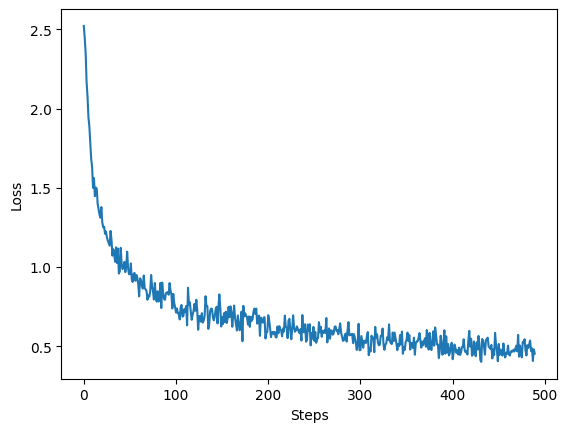

In [80]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

### **2.3 Change the Classification Head of an already trained Model on CIFAR-100**

In this exercise, we will modify the classification head of a pre-trained model on CIFAR-10 to adapt it to the CIFAR-100 dataset. This process involves changing the output layer of the model to accommodate the 100 classes in CIFAR-100 instead of the 10 classes in CIFAR-10. By changing the classification head, we can repurpose the pre-trained model to perform well on a different task with minimal additional training.

We do this by employing a common technique in transfer learning, known as **layer freezing**, to adapt a pre-trained model to a new task with minimal training time. Layer freezing involves setting the `requires_grad` attribute of specific model parameters to `False`, effectively preventing them from being updated during the backpropagation process. By freezing all layers except for the final classification head, we retain the knowledge encoded in the pre-trained layers while allowing the model to learn task-specific features through the unfrozen layers.

This approach is usually developed in NLP and LLMs since the training of these models requires vast computational resources and large amounts of data. By fine-tuning the pre-trained model on a specific task, we can leverage the knowledge learned from the original training data and adapt it to new tasks with limited data.

In [81]:
# Load the CIFAR-100 dataset
trainset_cifar100 = torchvision.datasets.CIFAR100(root=dataset_dir, train=True, download=True, transform=transform_train)
trainloader_cifar100 = torch.utils.data.DataLoader(trainset_cifar100, batch_size=100, shuffle=True)

testset_cifar100 = torchvision.datasets.CIFAR100(root=dataset_dir, train=False, download=True, transform=transform_test)
testloader_cifar100 = torch.utils.data.DataLoader(testset_cifar100, batch_size=100, shuffle=False)

100%|██████████| 169M/169M [03:14<00:00, 868kB/s]


In [82]:
# Modify the classification head for CIFAR-100 (100 classes)

# Defined up: pretrained_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = pretrained_model
model.fc = nn.Linear(model.fc.in_features, 100) # from 10 to 100
model = model.to(device)

In our case, we freeze all layers except for the newly modified classification head by iterating through the model's parameters and setting `requires_grad = False` for each. Subsequently, we explicitly enable gradient computation (`requires_grad = True`) for the parameters in the classification head. This approach allows us to fine-tune the output layer to classify the 100 classes in the CIFAR-100 dataset while preserving the general features learned from the CIFAR-10 dataset, ensuring that the model adapts effectively to the new task using the information already learned from the previous task.

In [83]:
# Freeze all layers except the classification head
for param in model.parameters():
    param.requires_grad = False

# TODO: Unfreeze the classification head
for param in model.fc.parameters():
    param.requires_grad = True

In [84]:
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [85]:
num_epochs = 1

losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader_cifar100:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader_cifar100):.4f}")

Epoch [1/1], Loss: 3.2326


In [86]:
val_model(model, testloader_cifar100)

Accuracy of the network on the test images: 28.15%


Text(0, 0.5, 'Loss')

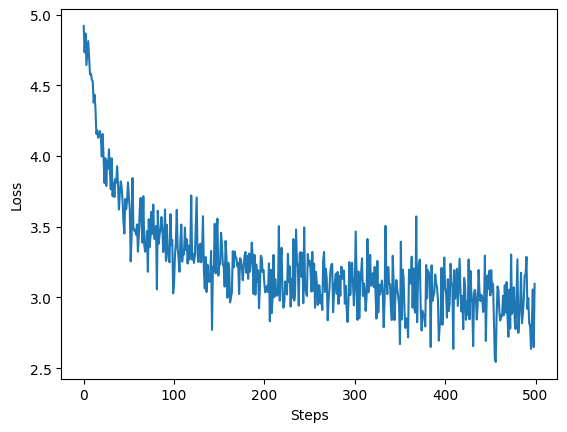

In [87]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

---

## **Exercise 3: PyTorch Computational Graph**

In this exercise, we will explore how PyTorch constructs a computational graph dynamically when performing operations on tensors. This graph is fundamental to PyTorch’s ability to compute gradients automatically during the backward pass, which is essential for training neural networks.

In [89]:
!pip install torchviz

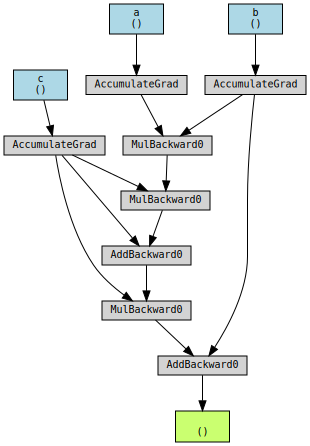

In [90]:
import torch
from torchviz import make_dot

# Define tensors with requires_grad=True to track operations
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = torch.tensor(4.0, requires_grad=True)

# Define a function involving these tensors
y = (a*b*c+c)*c + b

# Visualize the computational graph
make_dot(y, params={"a": a, "b": b, "c": c})

### **Backpropagation in PyTorch**


Let's use the following example, and let PyTorch build the computational graph for us.

![computational_graph](https://github.com/GameRule17/llm-labs-polito-notebooks/blob/main/lab01/computational_graph.png?raw=1)

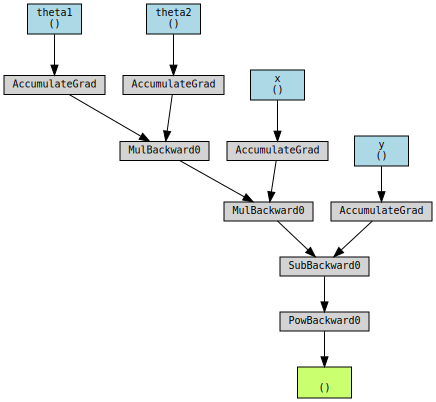

In [96]:
import torch
from torchviz import make_dot

import torch

# TODO: define the tensors and compute the loss
# Define theta1, theta2, x, and y as tensors, then compute the loss
# Notes:
# - set theta1 = 2.0, theta2 = 3.0, x = 1.0, y = 3.0
# - the loss is defined as (theta1 * theta2 * x - y)^2
# - all the tensors should be specified to require gradients
theta1 = torch.tensor(2.0, requires_grad=True)
theta2 = torch.tensor(3.0, requires_grad=True)
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

loss = (theta1 * theta2 * x - y)**2

# TODO: Visualize the computational graph
make_dot(loss, params={"theta1": theta1, "theta2": theta2, "x": x, "y": y})

In [97]:
# Perform backpropagation to compute gradients
loss.backward()

print("Loss:", loss.item())
print("Gradients:")
print("dL/d(theta1):", theta1.grad)
print("dL/d(theta2):", theta2.grad)

Loss: 9.0
Gradients:
dL/d(theta1): tensor(18.)
dL/d(theta2): tensor(12.)


### Evaluating the Partial Derivatives

![backpropagation](https://github.com/GameRule17/llm-labs-polito-notebooks/blob/main/lab01/backpropagation.png?raw=1)

Given the function:

$\mathcal{L} = \left( \theta_1 \theta_2 x - y \right)^2$

we can use the chain rule from calculus, and apply it from the end of the computational graph backwards to compute the partial derivatives of the loss function $\mathcal{L}$ with respect to the parameters $\theta_1$ and $\theta_2$.

$\frac{\partial \mathcal{L}}{\partial c} = \frac{\partial c^2}{\partial c} = 2c$

$\frac{\partial \mathcal{L}}{\partial a} = \frac{\partial \mathcal{L}}{\partial b} \frac{\partial b}{\partial a} = 2c \frac{\partial ax}{\partial a} = 2cx$

$\frac{\partial \mathcal{L}}{\partial b} = \frac{\partial \mathcal{L}}{\partial c} \frac{\partial c}{\partial b} = 2c \frac{\partial (b - y)}{\partial b} = 2c$

$\frac{\partial \mathcal{L}}{\partial \theta_1} = \frac{\partial \mathcal{L}}{\partial a} \frac{\partial a}{\partial \theta_1} = 2cx \frac{\partial \theta_1 \theta_2}{\partial \theta_1} = 2cx \theta_2$

$\frac{\partial \mathcal{L}}{\partial \theta_2} = \frac{\partial \mathcal{L}}{\partial a} \frac{\partial a}{\partial \theta_2} = 2cx \frac{\partial \theta_1 \theta_2}{\partial \theta_2} = 2cx \theta_1$

so:

$\frac{\partial \mathcal{L}}{\partial \theta_1} = 2 (\theta_1 \theta_2 x - y) x \theta_2$

$\frac{\partial \mathcal{L}}{\partial \theta_2} = 2 (\theta_1 \theta_2 x - y) x \theta_1$

---

By changing the variables with the values given in the code, we can compute the partial derivatives of the loss function with respect to the parameters $\theta_1$ and $\theta_2$.
In fact, considering the values:

- $x = 1$
- $y = 3$
- $\theta_1 = 2$
- $\theta_2 = 3$

we can compute the partial derivatives of the loss function $\mathcal{L}$ with respect to the parameters $\theta_1$ and $\theta_2$.

$\frac{\partial \mathcal{L}}{\partial \theta_1} = 18$

$\frac{\partial \mathcal{L}}{\partial \theta_2} = 12$









<span style="color:red">Extra stuff!</span>

The previous gradient computations have involved each weight ($\theta_1$, $\theta_2$) only once. However, in practice, the same weight may be used multiple times to compute the same loss. For instance, we may have a loss involving two terms, using the same weight $\theta$ twice. In these cases, we typically sum multiple loss contributions and weigh each of them differently (e.g., with a coefficient).

Or, as we saw earlier, we generally compute losses for mini-batches of data. This means that we use the same weight multiple times (once per sample in the mini-batch).

Consider the following losses. Compute the gradients w.r.t. the model's parameter $\theta$ analytically:
- $\mathcal{L} = |\theta x - y| + \lambda (\theta x - y)^2$
- $\mathcal{L} = \frac{1}{N}\sum_{i=1}^N (\theta x_i - y_i)^2$

How can PyTorch handle these cases? (Remember, the AccumulateGrad node!).

Now, consider that a new gradient should be computed for every batch of data. How can PyTorch handle this? (Remember, the zero_grad() method!).